In [14]:
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix


In [15]:
import pandas as pd
import os

# Load CSV
csv_path = '/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv'
df = pd.read_csv(csv_path)

# Convert one-hot encoded labels to a single class label
df['label'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

# Add image path
image_dir = '/kaggle/input/ham1000-segmentation-and-classification/images'
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Final columns
df = df[['image', 'image_path', 'label']]
df.head()


,image,image_path,label
0,ISIC_0024306,/kaggle/input/ham1000-segmentation-and-classif...,NV
1,ISIC_0024307,/kaggle/input/ham1000-segmentation-and-classif...,NV
2,ISIC_0024308,/kaggle/input/ham1000-segmentation-and-classif...,NV
3,ISIC_0024309,/kaggle/input/ham1000-segmentation-and-classif...,NV
4,ISIC_0024310,/kaggle/input/ham1000-segmentation-and-classif...,MEL


In [16]:
import os
import pandas as pd

# Paths
base_path = '/kaggle/input/ham1000-segmentation-and-classification'
csv_path = os.path.join(base_path, 'GroundTruth.csv')
image_dir = os.path.join(base_path, 'images')

# Load CSV
df = pd.read_csv(csv_path)

# Convert one-hot to label names
df['label'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

# Add image file paths
df['image'] = df['image']  # Already present
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Drop rows where image doesn't exist (safety)
df = df[df['image_path'].apply(os.path.exists)]

# Keep only necessary columns
df = df[['image_path', 'label']]


In [17]:
print(df['label'].value_counts())

label
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% testing
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))

Train samples: 8012
Test samples: 2003


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_df['label'].unique()), activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Train the Model

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,  # Adjust epochs based on your requirement
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746547480.288596     143 service.cc:148] XLA service 0x7a0a04003220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746547480.289556     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746547480.289575     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746547481.212822     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/250 ━━━━━━━━━━━━━━━━━━━━ 1:20:03 19s/step - accuracy: 0.0312 - loss: 3.3574

I0000 00:00:1746547486.162494     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 253s 938ms/step - accuracy: 0.6406 - loss: 1.1435 - val_accuracy: 0.7142 - val_loss: 0.8360
Epoch 2/10
  1/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7188 - loss: 0.8331

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7188 - loss: 0.8331 - val_accuracy: 0.6316 - val_loss: 1.0519
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 522ms/step - accuracy: 0.7102 - loss: 0.8358 - val_accuracy: 0.7218 - val_loss: 0.7813
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.7500 - loss: 0.8742 - val_accuracy: 0.5263 - val_loss: 0.8830
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 518ms/step - accuracy: 0.7191 - loss: 0.7983 - val_accuracy: 0.7248 - val_loss: 0.7748
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.6250 - loss: 1.0410 - val_accuracy: 0.6316 - val_loss: 0.8011
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 515ms/step - accuracy: 0.7364 - loss: 0.7635 - val_accuracy: 0.7354 - val_loss: 0.7546
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6875 - loss: 0.9806 - val_accuracy: 0.6316 - val_loss: 0.8769
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 522ms/step - accuracy: 0.7411 - loss: 0.7489 - val_

Evaluate the Model

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.7296 - loss: 0.7444
Test Loss: 0.7330761551856995
Test Accuracy: 0.7394153475761414


predict the model

In [25]:
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)

62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step


Save the model

In [26]:
model.save('skin_cancer_model.h5')

Load and Predict the Sample Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


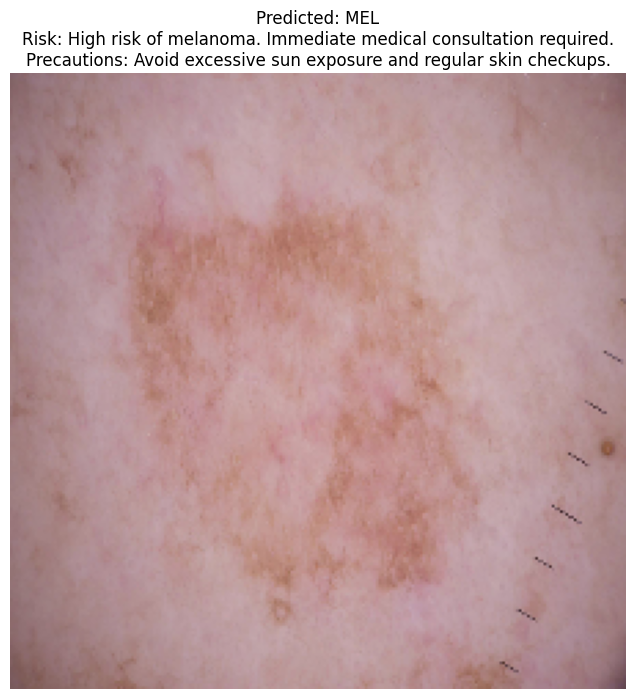

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define risk levels and precautions for each class
disease_info = {
    'MEL': {
        'risk': 'High risk of melanoma. Immediate medical consultation required.',
        'precautions': 'Avoid excessive sun exposure and regular skin checkups.'
    },
    'NV': {
        'risk': 'Normal, but keep monitoring for any changes.',
        'precautions': 'Maintain a healthy lifestyle and regular skin checkups.'
    },
    'BCC': {
        'risk': 'Moderate risk, can be treated surgically.',
        'precautions': 'Avoid direct sun exposure, use sunscreen, and consult a dermatologist.'
    },
    'AKIEC': {
        'risk': 'Moderate risk, may require further analysis.',
        'precautions': 'Avoid tanning and protect your skin from sunburns.'
    },
    'BKL': {
        'risk': 'Low risk, usually benign.',
        'precautions': 'Keep an eye on changes in appearance, and consult a doctor if any concerns arise.'
    },
    'DF': {
        'risk': 'Low risk, generally harmless.',
        'precautions': 'Monitor the skin lesion for changes, and consult if concerned.'
    },
    'VASC': {
        'risk': 'Low to moderate risk, requires medical attention.',
        'precautions': 'Consult a healthcare provider to rule out vascular conditions.'
    }
}

# Load and preprocess the sample image
sample_image_path = '/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0024338.jpg'  # Update with the actual path
img = image.load_img(sample_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a prediction
prediction = model.predict(img_array)

# Get the predicted class (index of the maximum probability)
predicted_class_index = np.argmax(prediction, axis=1)

# Get the label of the predicted class
class_labels = train_generator.class_indices  # This gives the mapping of class names to indices
predicted_class_label = {v: k for k, v in class_labels.items()}  # Invert the class indices
predicted_label = predicted_class_label[predicted_class_index[0]]

# Get risk and precautions based on the predicted class
risk_level = disease_info.get(predicted_label, {}).get('risk', 'No information available.')
precautions = disease_info.get(predicted_label, {}).get('precautions', 'No precautions available.')

# Display the sample image and prediction results
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}\nRisk: {risk_level}\nPrecautions: {precautions}")
plt.axis('off')  # Hide the axis
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step
Classification Report:

              precision    recall  f1-score   support

       AKIEC       0.41      0.11      0.17        65
         BCC       0.56      0.39      0.46       103
         BKL       0.40      0.40      0.40       220
          DF       1.00      0.00      0.00        23
         MEL       0.45      0.29      0.35       223
          NV       0.83      0.94      0.88      1341
        VASC       0.63      0.61      0.62        28

    accuracy                           0.74      2003
   macro avg       0.61      0.39      0.41      2003
weighted avg       0.71      0.74      0.71      2003



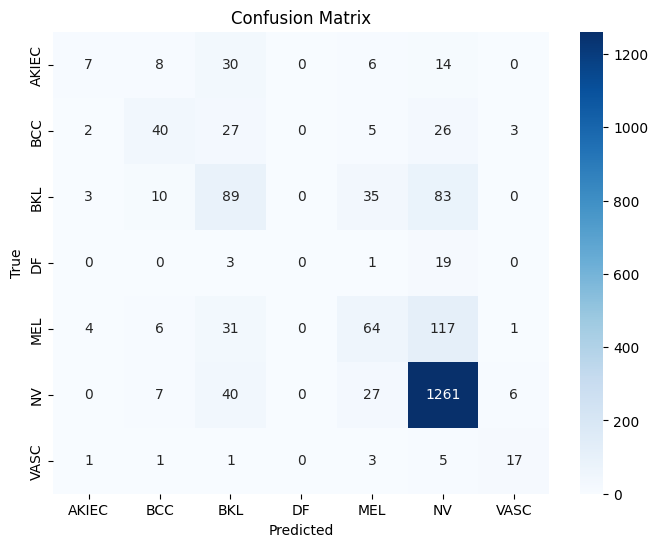

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report with zero_division to handle undefined metrics
report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=1)  # set zero_division to 1
print("Classification Report:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
